In [1]:
import rioxarray
import numpy as np
import matplotlib.pyplot as plt
from pyproj import Transformer
from scipy import interpolate
%run -i marsh_funcs.py

In [2]:
# here is a rotated grid
dxg = 30.
dyg = 30.
lenxg = 1600.
lenyg = 3200.
xg = np.arange( 0, lenxg+dxg, dxg )
yg = np.arange( 0, lenyg+dyg, dyg )

print(xg)
print(yg)
xrg, yrg = np.meshgrid( xg, yg )
print(xrg)

[   0.   30.   60.   90.  120.  150.  180.  210.  240.  270.  300.  330.
  360.  390.  420.  450.  480.  510.  540.  570.  600.  630.  660.  690.
  720.  750.  780.  810.  840.  870.  900.  930.  960.  990. 1020. 1050.
 1080. 1110. 1140. 1170. 1200. 1230. 1260. 1290. 1320. 1350. 1380. 1410.
 1440. 1470. 1500. 1530. 1560. 1590. 1620.]
[   0.   30.   60.   90.  120.  150.  180.  210.  240.  270.  300.  330.
  360.  390.  420.  450.  480.  510.  540.  570.  600.  630.  660.  690.
  720.  750.  780.  810.  840.  870.  900.  930.  960.  990. 1020. 1050.
 1080. 1110. 1140. 1170. 1200. 1230. 1260. 1290. 1320. 1350. 1380. 1410.
 1440. 1470. 1500. 1530. 1560. 1590. 1620. 1650. 1680. 1710. 1740. 1770.
 1800. 1830. 1860. 1890. 1920. 1950. 1980. 2010. 2040. 2070. 2100. 2130.
 2160. 2190. 2220. 2250. 2280. 2310. 2340. 2370. 2400. 2430. 2460. 2490.
 2520. 2550. 2580. 2610. 2640. 2670. 2700. 2730. 2760. 2790. 2820. 2850.
 2880. 2910. 2940. 2970. 3000. 3030. 3060. 3090. 3120. 3150. 3180. 3210.]
[[   0

In [3]:
# make a local grid to interpolate the data onto
# this will be in meters, from 0 to xlen and 0 to ylen, and rotated with x positive alongshore
# lat/lon for lower left corner, and azimuth of grid (CCW from due east)
ll_lat = 37.9
ll_lon = -75.5
theta = -25. # angle in degrees, CCW from due east
print('Lon, lat of ll corner:')
print(ll_lon, ll_lat)

# convert ll corner to UTM18
geo_to_utm18 = Transformer.from_crs( 'epsg:4326', 'epsg:26918', always_xy=True ) # WGS84 to UTM18
e0, n0 = geo_to_utm18.transform( ll_lon, ll_lat)
print('Easting, northing of grid origin:')
print(e0, n0 )

# how big should the grid be?
dxdy = 30 # landsat 30-m data
xlen = 520*30
ylen = 1800*30

# after this call, xrot and yrot are 1-d arrays with the the local grid coords (0-xlen, 0-ylen), and xu, yu is a meshgrid of UTM locations for the local grid
xu, yu, xrot, yrot, xcoords, ycoords = make_grid(name='assateague', e0=e0, n0=n0, xlen=xlen, ylen=ylen, dxdy=dxdy, theta=theta)
# convert UTM grid to ll
utm18_to_geo = Transformer.from_crs( 'epsg:26918', 'epsg:4326', always_xy=True ) # UTM18 to WGS84 
lonc, latc = utm18_to_geo.transform( xu, yu )

# make a bounding box in lat/lon space
# this is the subset of the big data grid we will load, and we pad a little to make sure our UTM grid fits inside.
lonmin = np.min(lonc)-.01
lonmax = np.max(lonc)+.01
latmax = np.max(latc)+.01
latmin = np.min(latc)-.01


Lon, lat of ll corner:
-75.5 37.9
Easting, northing of grid origin:
456040.79338173766 4194837.67312873
make_grid: Shape of xrot, yrot:  (1800, 520) (1800, 520)
corners x, corners y]
[[ 456060.72727247 4194844.92847161]
 [ 470171.93951663 4188264.76213631]
 [ 492980.64710278 4237178.19340267]
 [ 478869.43485861 4243758.35973798]
 [ 456060.72727247 4194844.92847161]]
Saving to assateague.csv


In [4]:
# read the data
# 2014 https://www.sciencebase.gov/catalog/item/5e4d5ed3e4b0ff554f6d1833
# 2018 https://www.sciencebase.gov/catalog/item/5e4d644ae4b0ff554f6d5473
r18 = rioxarray.open_rasterio( 'L8_2018_ATL_Unveg_Veg_Water_UVVR.tif' )
infile = 'L8_2014_ATL_Unveg_Veg_Water_UVVR.tif'
r14 = rioxarray.open_rasterio( 'L8_2014_ATL_Unveg_Veg_Water_UVVR.tif' )
r14

<xarray.DataArray (band: 4, y: 74925, x: 60625)> Size: 73GB
[18169312500 values with dtype=float32]
Coordinates:
  * band         (band) int64 32B 1 2 3 4
  * x            (x) float64 485kB -82.36 -82.35 -82.35 ... -66.02 -66.02 -66.02
  * y            (y) float64 599kB 45.39 45.39 45.39 45.39 ... 25.2 25.2 25.2
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:       Area
    RepresentationType:  ATHEMATIC
    _FillValue:          -inf
    scale_factor:        1.0
    add_offset:          0.0

In [5]:
# read in UVVR (band 1) from large dataset for clipped region
# I am not checking to see if lat/lon are the same and aligned in both datasets
a = r18.rio.clip_box( minx = lonmin, miny = latmin, maxx=lonmax, maxy=latmax )
uvvr18 = a[1,:,:].values
lon = a.x.values
lat = a.y.values
ny = len(lat)
nx = len(lon)
a = r14.rio.clip_box( minx = lonmin, miny = latmin, maxx=lonmax, maxy=latmax )
uvvr14 = a[1,:,:].values
lon = a.x.values
lat = a.y.values
ny = len(lat)
nx = len(lon)
a

<xarray.DataArray (band: 4, y: 1932, x: 1632)> Size: 50MB
[12612096 values with dtype=float32]
Coordinates:
  * band         (band) int64 32B 1 2 3 4
  * x            (x) float64 13kB -75.51 -75.51 -75.51 ... -75.07 -75.07 -75.07
  * y            (y) float64 15kB 38.35 38.35 38.35 38.35 ... 37.83 37.83 37.83
    spatial_ref  int64 8B 0
Attributes:
    AREA_OR_POINT:       Area
    RepresentationType:  ATHEMATIC
    scale_factor:        1.0
    add_offset:          0.0
    _FillValue:          -inf

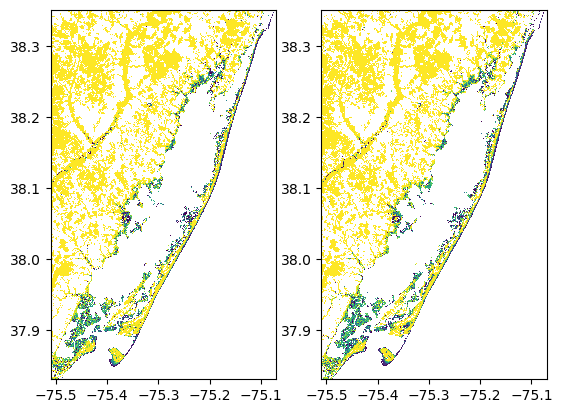

In [6]:
# plot in lat/lon to check
fig, (ax0, ax1) = plt.subplots(1, 2)
ax0.pcolormesh(lon, lat, uvvr18)
ax1.pcolormesh(lon, lat, uvvr14)

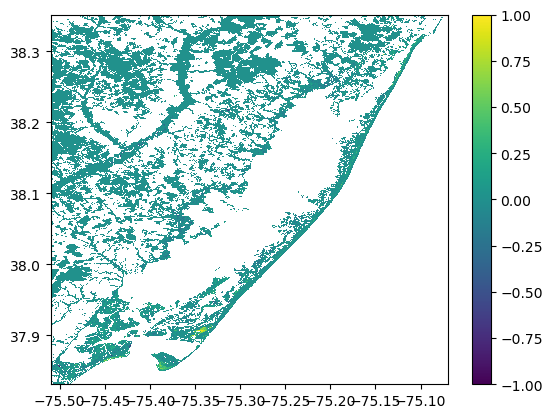

In [7]:
# not much difference between them
plt.pcolormesh(lon,lat,uvvr18-uvvr14)
plt.colorbar()

In [8]:
print( np.shape(lon), np.shape(lat), np.shape(uvvr18))


(1632,) (1932,) (1932, 1632)


In [9]:
# use the fast grid interpolator
f18 = interpolate.RegularGridInterpolator( (lat, lon), uvvr18, method='nearest')  
f14 = interpolate.RegularGridInterpolator( (lat, lon), uvvr14, method='nearest')   

# Array for interpolated elevations
uvvri18=np.nan*np.ones((ny,nx))
uvvri14=np.nan*np.ones((ny,nx))
    
# this is the fast iteration, which only works when all of the source points fall inside the target box
uvvri18=f18((latc, lonc))
uvvri14=f14((latc, lonc))


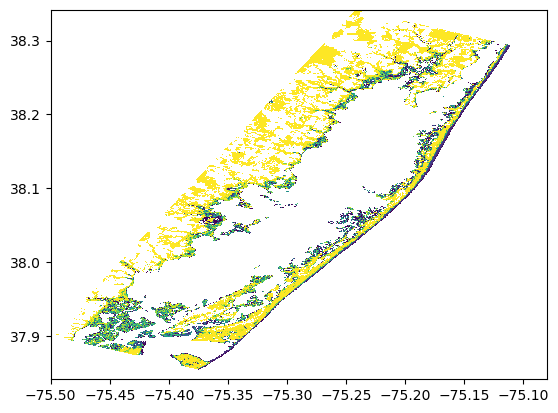

In [10]:
# plot on lat/lon of local grid
plt.pcolormesh(lonc,latc,uvvri18)

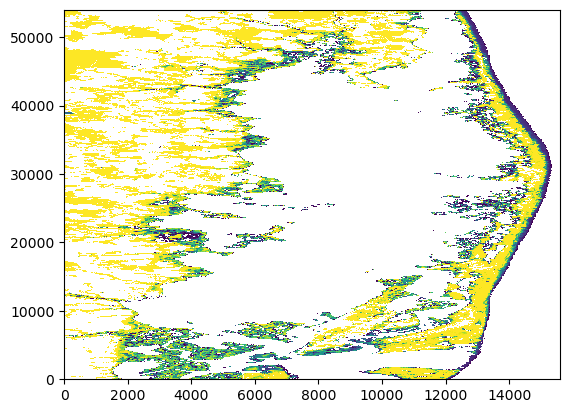

In [11]:
# plot on rotated grid
plt.pcolormesh(xrot, yrot, uvvri18 )

333


C:\Users\csherwood\AppData\Local\Temp\1\ipykernel_26164\1606415620.py:11: RuntimeWarning: Mean of empty slice
  plt.plot( xrot[0,:], np.nanmean( uvvri18[plist[i]:plist[i+1],:], axis=0 ))


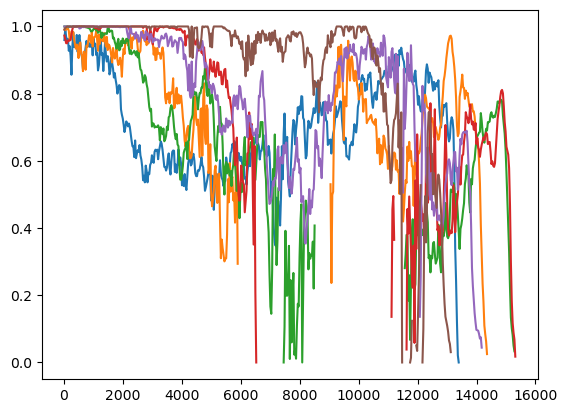

In [14]:
# how many profiles to average?
# Say, 10 km
numpro = int(10000/dxdy)
print(numpro)

plist = np.arange( 0, ylen, numpro)
#print(plist)
profiles = np.zeros((len(plist),len(uvvri18[0,:])))
tot_area = np.zeros(len(plist))
for i in range( len( plist)-1) :
    plt.plot( xrot[0,:], np.nanmean( uvvri18[plist[i]:plist[i+1],:], axis=0 ))

C:\Users\csherwood\AppData\Local\Temp\1\ipykernel_26164\1566828452.py:1: RuntimeWarning: Mean of empty slice
  plt.plot( xrot[0,:], np.nanmean( uvvri18, axis=0 ) )
C:\Users\csherwood\AppData\Local\Temp\1\ipykernel_26164\1566828452.py:2: RuntimeWarning: Mean of empty slice
  plt.plot( xrot[0,:], np.nanmean( uvvri14, axis=0 ) )


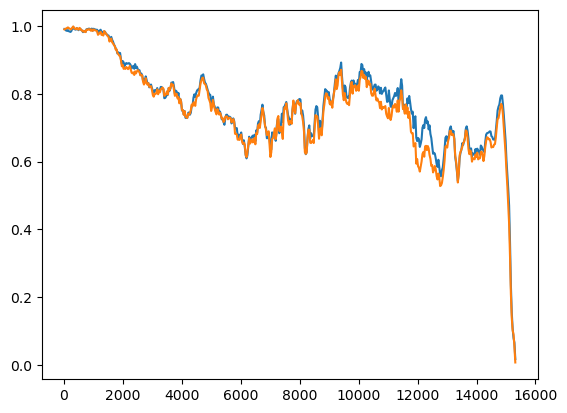

In [15]:
plt.plot( xrot[0,:], np.nanmean( uvvri18, axis=0 ) )
plt.plot( xrot[0,:], np.nanmean( uvvri14, axis=0 ) )